In [61]:
#importing general packages
import os
import random
import sys
import librosa 
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import soundfile
import os, glob, pickle
import numpy as np
from sklearn import preprocessing

from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

# to play the audio files
import IPython.display as ipd

import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf

##keras 
import keras 
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import ReduceLROnPlateau, History, CSVLogger
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

##Rest
from scipy.fftpack import fft
from scipy import signal 
from scipy.io import wavfile
from tqdm import tqdm


# DATA PREPARATION
We will use a dataset consisting of various actors speaking in different emotions which is named RAVDESS

In [2]:
dir_list = os.listdir('ravdess_data/')
dir_list.sort()
print(dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [6]:
data_df = pd.DataFrame(columns=['path', 'source','actor','gender',
                                'intensity','statement', 'repitition','emotion'])
count = 0
for i in dir_list:
    file_list =os.listdir('ravdess_data/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path ='ravdess_data/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 ==0:
            gender ="female"
        else:
            gender = "male"
        if nm[3] =='01':
            intensity = 0
        else:
            intensity = 1
        if nm[4] =='01':
            statement = 0
        else:
            statement = 1
        if nm[5] =='01':
            repeat = 0
        else:
            repeat = 1
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1 

In [7]:
print (len(data_df))
data_df.head()

1440


,path,source,actor,gender,intensity,statement,repitition,emotion
0,ravdess_data/Actor_01/03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1
1,ravdess_data/Actor_01/03-01-01-01-01-02-01.wav,1,1,male,0,0,1,1
2,ravdess_data/Actor_01/03-01-01-01-02-01-01.wav,1,1,male,0,1,0,1
3,ravdess_data/Actor_01/03-01-01-01-02-02-01.wav,1,1,male,0,1,1,1
4,ravdess_data/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2


# FEATURE EXTRACTION

In [8]:
#Plotting the audio file's waveform and its spectogram 
filename = data_df.path[90]
print(filename)
samples, sample_rate = librosa.load(filename)
sample_rate, samples 

ravdess_data/Actor_02/03-01-05-01-02-01-02.wav


(22050,
 array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         3.7739329e-07, -3.1984533e-07,  0.0000000e+00], dtype=float32))

In [9]:
len(samples), sample_rate

(83139, 22050)

In [10]:
def log_specgram(audio, sample_rate, window_size=20,
                  step_size =10, eps = 1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate/ 1e3))
    freqs, times, spec = signal.spectrogram(audio, 
                                           fs =sample_rate,
                                           window='hann',
                                           nperseg=nperseg,
                                           noverlap=noverlap,
                                           detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)
    

In [11]:
sample_rate/ len(samples)

0.26521848951755495

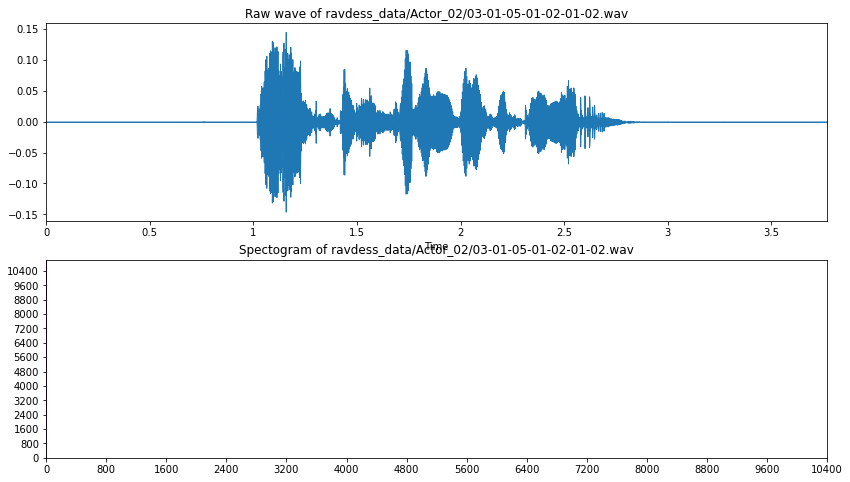

In [12]:
#Plotting the waveform and spectogram 
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' +filename)
ax1.set_ylabel =('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
          extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(freqs[::16])
ax2.set_title('Spectogram of ' +filename)
ax1.set_ylabel =('Freqs in Hz')
ax1.set_xlabel =('Seconds')



In [13]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram =(spectrogram - mean)/std

In [14]:
#Trim the silence voice 
aa, bb =librosa.effects.trim(samples, top_db=30)
aa, bb

(array([3.2075706e-05, 1.0230949e-05, 4.0718164e-06, ..., 7.2745635e-05,
        3.7834552e-04, 5.2120403e-04], dtype=float32),
 array([21504, 61440]))

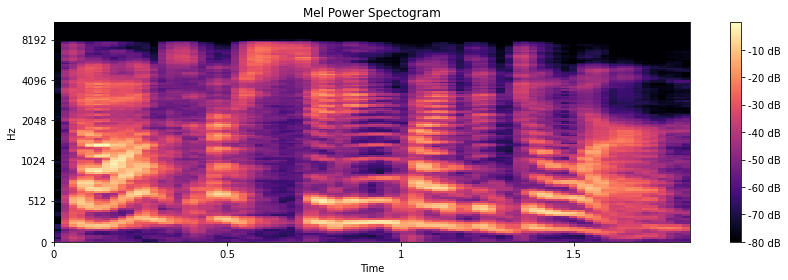

In [15]:
#Plotting mel power spectrogram 
S =librosa.feature.melspectrogram(aa, sr= sample_rate, n_mels=128)
#convert to log scale(dB), using the peak power (max) as reference
log_S = librosa.power_to_db(S, ref=np.max)

#displaying the spectogram 
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel Power Spectogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

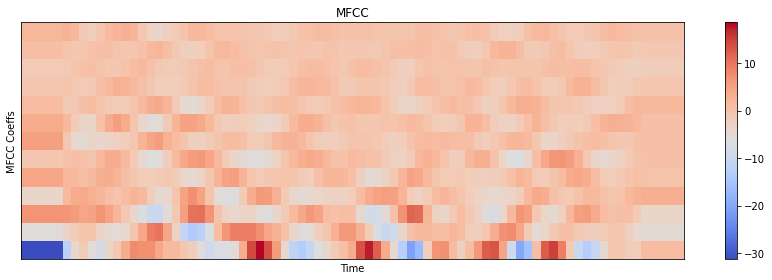

In [16]:
#Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

#pad on the first and second delas 
delta2_mfcc = librosa.feature.delta(mfcc, order =2)

plt.figure(figsize=(12,4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC Coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [17]:
#Original sound
ipd.Audio(samples, rate=sample_rate)

In [18]:
#Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [19]:
#Silence trimmed sound by manuel trimming 
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)


In [20]:
#DEFINING THE TRUTH LABEL 
# 2 classes- positive and negative 

#positive: calm, happy
#negative: angry, fearful, sad
label2_list =[]
for i in range(len(data_df)):
    if data_df.emotion[i] ==2: #calm
        lb ="_positive"
    elif data_df.emotion[i] ==3: # happy
            lb ="_positive"
    elif data_df.emotion[i] ==4: # sad
            lb ="_negative"
    elif data_df.emotion[i] ==5: # angry
            lb ="_negative"
    elif data_df.emotion[i] ==6: # fearful
            lb ="_negative"
    else: 
        lb= "_none"
    #add gender to the label 
    label2_list.append(data_df.gender[i] + lb)
len(label2_list)

1440

In [21]:
#3 class: Positive , negative and neutral 
#positive: happy
#negative: angry, fearful, sad
#neutral: calm, neutral
label3_list =[]
for i in range(len(data_df)):
    if data_df.emotion[i] ==1: #neutral
        lb ="_neutral"
    elif data_df.emotion[i] ==2: # calm
            lb ="_neutral"
    elif data_df.emotion[i] ==3: # happy
            lb ="_positive"
    elif data_df.emotion[i] ==4: # sad
            lb ="_negative"
    elif data_df.emotion[i] ==5: # angry
            lb ="_negative"
    elif data_df.emotion[i] ==6: # Fearful
            lb ="_negative"
    else: 
        lb= "_none"
    #add gender to the label 
    label3_list.append(data_df.gender[i] + lb)
len(label3_list)

1440

In [22]:
#5 class: angry, calm, sad, happy and fearful 
label5_list =[]
for i in range(len(data_df)):
    
    if data_df.emotion[i] ==2:       
        lb ="_calm"
    elif data_df.emotion[i] ==3:       
        lb ="_happy"
    elif data_df.emotion[i] ==4: #
        lb ="_sad"
    elif data_df.emotion[i] ==5:
        lb ="_angry"
    elif data_df.emotion[i] ==6: 
        lb ="_fearful"
    else: 
        lb = "_none"
    #add gender to the label 
    label5_list.append(data_df.gender[i] + lb)
len(label5_list)


1440

In [23]:
#all classes
label8_list =[]
for i in range(len(data_df)):
    if data_df.emotion[i] ==1:       
        lb ="_neutral"   
    if data_df.emotion[i] ==2:       
        lb ="_calm"
    elif data_df.emotion[i] ==3:       
        lb ="_happy"
    elif data_df.emotion[i] ==4: 
        lb ="_sad"
    elif data_df.emotion[i] ==5:
        lb ="_angry"
    elif data_df.emotion[i] ==6: 
        lb ="_fearful"
    elif data_df.emotion[i] ==5:
        lb ="_disgust"
    elif data_df.emotion[i] ==6: 
        lb ="_surprised"
    else: 
        lb = "_none"
    #add gender to the label 
    label8_list.append(data_df.gender[i] + lb)
len(label8_list)


1440

In [24]:
#select the label set you want by commenting the unwanted 
data_df['label'] = label2_list
#data_df['label'] = label3_list
#data_df['label'] = label5_list
#data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repitition,emotion,label
0,ravdess_data/Actor_01/03-01-01-01-01-01-01.wav,1,1,male,0,0,0,1,male_none
1,ravdess_data/Actor_01/03-01-01-01-01-02-01.wav,1,1,male,0,0,1,1,male_none
2,ravdess_data/Actor_01/03-01-01-01-02-01-01.wav,1,1,male,0,1,0,1,male_none
3,ravdess_data/Actor_01/03-01-01-01-02-02-01.wav,1,1,male,0,1,1,1,male_none
4,ravdess_data/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2,male_positive


In [25]:
print(data_df.label.value_counts().keys())

Index(['female_negative', 'male_negative', 'female_none', 'male_none',
       'male_positive', 'female_positive'],
      dtype='object')


# DATA VISUALIZATION

In [26]:
#plotting the emotion distribution 
def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    tmp_df =pd.DataFrame()
    tmp_df['Emotion'] =list(dist.keys())
    tmp_df['Count'] =list(dist)
    fig, ax = plt.subplots(figsize=(14,7))
    ax = sns.barplot(x='Emotion', y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    

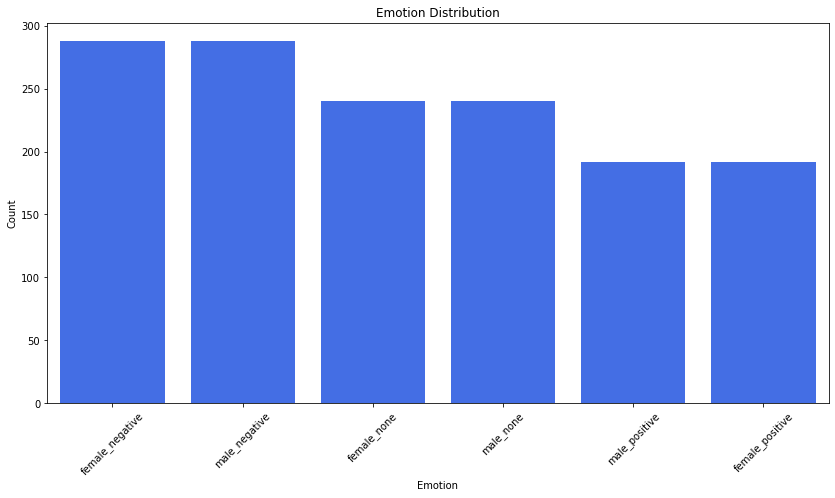

In [27]:
#displaying the ditribution of emotions in the dataset
a= data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

In [28]:
# Female Data set 
##uncomment all below to use the female dataset 

#data2_df = data_df.copy()
#data2_df = data2_df[data2_df.label != "male_none"]
#data2_df = data2_df[data2_df.label != "female_none"]
#data2_df = data2_df[data2_df.label != "male_happy"]
#data2_df = data2_df[data2_df.label != "male_angry"]
#data2_df = data2_df[data2_df.label != "male_sad"]
#data2_df = data2_df[data2_df.label != "male_fearful"]
#data2_df = data2_df[data2_df.label != "male_calm"]
#data2_df = data2_df[data2_df.label != "male_positive"]
#data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

#tmp1 = data2_df[data2_df.actor == 22]
#tmp2 = data2_df[data2_df.actor == 24]
#data3_df = pd.concat([tmp1, tmp2], ignore_index=True).reset_index(drop=True)
#data2_df = data2_df[data2_df.actor != 22]
#data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
#data2_df.head()



In [29]:
#Male dataset
##uncomment all below to use the female dataset 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3], ignore_index=True).reset_index(drop=True)
tmp1 = data2_df[data2_df.actor != 21]
tmp2 = data2_df[data2_df.actor != 22]
tmp3 = data2_df[data2_df.actor != 23].reset_index(drop=True)
tmp4 = data2_df[data2_df.actor != 24].reset_index(drop=True)

#printing the dataset of the male audio files 
print(len(data2_df))
data2_df.head()
#the dataset contains each of the audio files's source, actor, gender, intensity, statement, repitition, emotion and label 

480


,path,source,actor,gender,intensity,statement,repitition,emotion,label
0,ravdess_data/Actor_01/03-01-02-01-01-01-01.wav,1,1,male,0,0,0,2,male_positive
1,ravdess_data/Actor_01/03-01-02-01-01-02-01.wav,1,1,male,0,0,1,2,male_positive
2,ravdess_data/Actor_01/03-01-02-01-02-01-01.wav,1,1,male,0,1,0,2,male_positive
3,ravdess_data/Actor_01/03-01-02-01-02-02-01.wav,1,1,male,0,1,1,2,male_positive
4,ravdess_data/Actor_01/03-01-02-02-01-01-01.wav,1,1,male,1,0,0,2,male_positive


In [30]:
print(len(data3_df))
data3_df.head()

80


,path,source,actor,gender,intensity,statement,repitition,emotion,label
0,ravdess_data/Actor_21/03-01-02-01-01-01-21.wav,1,21,male,0,0,0,2,male_positive
1,ravdess_data/Actor_21/03-01-02-01-01-02-21.wav,1,21,male,0,0,1,2,male_positive
2,ravdess_data/Actor_21/03-01-02-01-02-01-21.wav,1,21,male,0,1,0,2,male_positive
3,ravdess_data/Actor_21/03-01-02-01-02-02-21.wav,1,21,male,0,1,1,2,male_positive
4,ravdess_data/Actor_21/03-01-02-02-01-01-21.wav,1,21,male,1,0,0,2,male_positive


In [31]:
#getiing the features of audio files using librosa 
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate =librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=4, sr=22050*2, offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 480/480 [00:19<00:00, 24.52it/s]


In [32]:
data.head()

,feature
0,"[-70.26908, -70.26908, -70.26908, -70.26908, -..."
1,"[-67.558426, -67.558426, -67.558426, -67.55842..."
2,"[-69.69399, -69.69399, -69.69399, -69.69399, -..."
3,"[-69.05305, -69.05305, -69.05305, -69.05305, -..."
4,"[-73.841805, -73.841805, -73.841805, -73.84180..."


In [33]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,335,336,337,338,339,340,341,342,343,344
0,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-67.558426,-67.558426,-67.558426,-67.558426,-67.558426,-67.558426,-65.434235,-65.635078,-67.558426,-67.558426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-69.053047,-69.053047,-69.053047,-69.053047,-69.053047,-69.005867,-69.053047,-69.053047,-69.053047,-68.918213,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
newdf = pd.concat([df3, labels], axis=1)

In [35]:
rnewdf = newdf.rename(index=str, columns={"0": "labels"})
len(rnewdf)

480

In [36]:
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,label
0,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_positive
1,-67.558426,-67.558426,-67.558426,-67.558426,-67.558426,-67.558426,-65.434235,-65.635078,-67.558426,-67.558426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_positive
2,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_positive
3,-69.053047,-69.053047,-69.053047,-69.053047,-69.053047,-69.005867,-69.053047,-69.053047,-69.053047,-68.918213,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_positive
4,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_positive


In [37]:
rnewdf.isnull().sum().sum #checking for null values 

<bound method Series.sum of 0          0
1          0
2          0
3          0
4          0
        ... 
341      466
342      466
343      468
344      468
label      0
Length: 346, dtype: int64>

In [38]:
rnewdf = rnewdf.fillna(0) #filling the missing data with values 0 
rnewdf.head() #printint the new dataset

,0,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,label
0,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
1,-67.558426,-67.558426,-67.558426,-67.558426,-67.558426,-67.558426,-65.434235,-65.635078,-67.558426,-67.558426,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
2,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
3,-69.053047,-69.053047,-69.053047,-69.053047,-69.053047,-69.005867,-69.053047,-69.053047,-69.053047,-68.918213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
4,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive


# DATA AUGMENTATION


In [39]:
#DATA AUGMENTATION 
def plot_time_series(data):
    fig = plt.figure(figsize=(14,8))
    plt.title('Raw Wave')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0,1,len(data)), data)
    plt.show()
    
def noise(data):
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') +noise_amp*np.random.normal(size=data.shape[0])
    return data

def shift(data):
    s_range = int(np.random.unifrom(low=5, high=5)*500)
    return np.roll(data, s_range)

def stretch(data, rate=0.8):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch(data):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change = pitch_pm *2*(np.random.uniform())
    data = librosa.effects.pitch_shift(data.astype('float64'), sample_rate, n_steps=pitch_change, bins_per_octave=bins_per_octave)
    return data

def dyn_change(data):
    dyn_change = np.random.uniform(low=1.5, high=3)
    return (data*dyn_change)


def speedNpitch(data):
    length_change = np.random.uniform(low=0.8, high=1)
    speed_fac = 1.0/length_change
    tmp = np.interp(np.arrange(0, len(data), speed_fac), np.arrange(0, len(data)), data)
    data *= 0
    data[0:minlen] = tap[0:minlen]
    return data

    
    

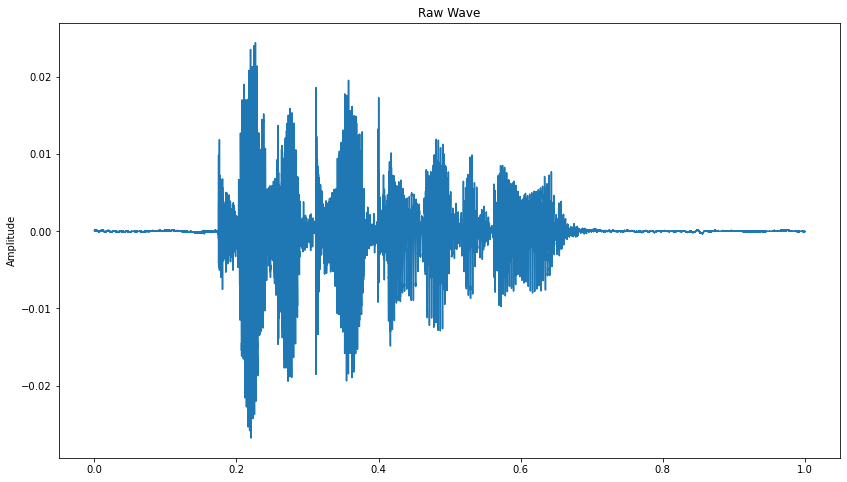

In [40]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast', duration=4, sr=22050*2, offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

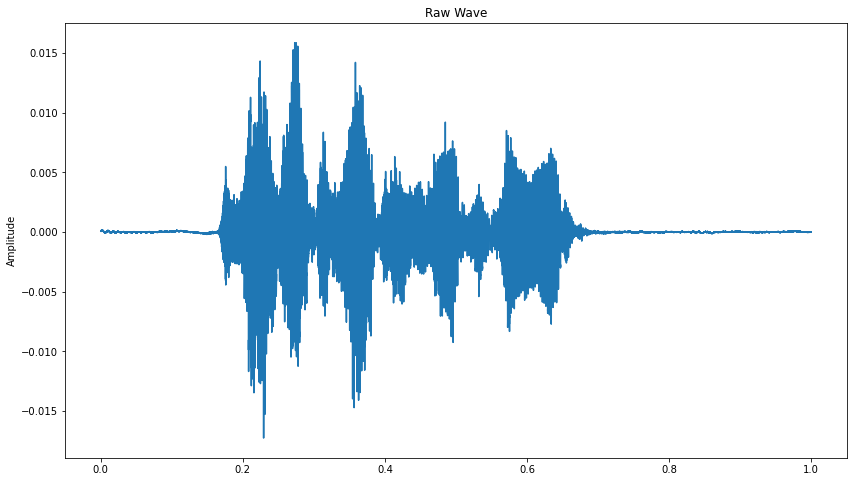

In [41]:
x = pitch(X)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [42]:
#AUGMENTATION METHOD 1 
syn_data1 = pd.DataFrame(columns=['feature','label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast', duration=4, sr=22050*2, offset=0.5)
    if data2_df.label[i]:
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0,1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 480/480 [00:23<00:00, 20.18it/s]


In [43]:
#AUGMENTATION METHOD 2
syn_data2 = pd.DataFrame(columns=['feature','label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast', duration=4, sr=22050*2, offset=0.5)
    if data2_df.label[i]:
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0,1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 480/480 [00:23<00:00, 20.34it/s]


In [44]:
len(syn_data1), len(syn_data2)

(480, 480)

In [45]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [46]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4, labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns ={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)


480

In [47]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,label
0,-57.694564,-58.016960,-57.269567,-55.986248,-55.346935,-55.840233,-56.702983,-57.292867,-57.873687,-56.155258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
1,-63.975298,-64.533007,-65.452379,-65.721539,-62.879045,-61.660520,-63.693366,-64.824622,-65.135066,-65.873562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
2,-65.463394,-64.395487,-62.423323,-62.255388,-63.403650,-62.598542,-63.488788,-64.858948,-64.376801,-63.696060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
3,-56.340568,-54.461512,-52.684680,-52.748948,-52.938660,-53.636539,-54.024376,-55.276725,-56.188551,-54.389214,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
4,-59.479923,-57.354870,-55.990992,-56.501690,-57.527501,-57.629156,-59.015969,-58.266206,-55.229838,-56.449655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive


In [48]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4, labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns ={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

480

In [49]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,label
0,-63.984861,-60.802346,-59.502114,-58.584178,-59.634899,-58.895286,-59.158927,-60.729388,-60.038756,-60.882343,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
1,-58.944936,-58.903437,-55.750815,-54.633464,-53.888456,-54.289472,-55.249232,-53.374116,-53.724970,-55.042918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
2,-61.162192,-59.373661,-57.394697,-59.994903,-60.504241,-59.622376,-58.985185,-58.922706,-58.037297,-57.985224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
3,-50.475752,-50.721559,-51.594087,-50.988556,-51.733118,-53.786448,-51.946384,-50.485071,-51.451119,-49.912142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
4,-73.833700,-73.855298,-73.844283,-73.650449,-73.837041,-73.607144,-73.836813,-73.865713,-73.935108,-73.845386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive


In [50]:
#combining the augmented data with original 
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index = True)
combined_df = combined_df.fillna(0)
combined_df.head()


,0,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,label
0,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,-70.269081,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
1,-67.558426,-67.558426,-67.558426,-67.558426,-67.558426,-67.558426,-65.434235,-65.635078,-67.558426,-67.558426,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
2,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,-69.693993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
3,-69.053047,-69.053047,-69.053047,-69.053047,-69.053047,-69.005867,-69.053047,-69.053047,-69.053047,-68.918213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive
4,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,-73.841805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_positive


# DATA MODELING 


In [51]:
#Stratified Shuffle split
X = combined_df.drop(['label'], axis = 1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

In [52]:
y_train.value_counts() #generating the counts of male_positive and male_negative audio in the training dataset

male_negative    691
male_positive    461
Name: label, dtype: int64

In [53]:
y_test.value_counts() #generating the counts of male_positive and male_negative audio in the testing dataset

male_negative    173
male_positive    115
Name: label, dtype: int64

In [54]:
X_train.isna().sum().sum() #checking if there are any null values in the dataset

0

In [55]:
#splitting the data into test and train sets 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

y_train = np_utils.to_categorical(le.fit_transform(y_train))
y_test = np_utils.to_categorical(le.fit_transform(y_test))

In [56]:
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [57]:
X_train.shape #displaying the size of the training dataset 

(1152, 345)

In [58]:
#CHANGING DIMENSION FOR CNN MODEL 
x_traincnn = np.expand_dims(X_train, axis =2) #changing the dimension for CNN model for training dataset
x_testcnn = np.expand_dims(X_test, axis =2) #changing the dimension for CNN model for testing dataset

In [59]:
#Set up keras utils function 
from keras import backend as K 
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0,1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0,1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return recall
def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0,1))) ==0:
        return 0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2*(p*r)/(p + r + K.epsilon())
    return f_score
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

        
    

In [62]:
#new model 
model = Sequential()
model.add(Conv1D(256,8, padding ='same', input_shape=(X_train.shape[1], 1)))
model.add(Activation('relu'))
model.add(Conv1D(256,8, padding ='same'))
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128,8, padding ='same'))
model.add(Activation('relu'))
model.add(Conv1D(128,8, padding ='same'))
model.add(Activation('relu'))
model.add(Conv1D(128,8, padding ='same'))
model.add(Activation('relu'))
model.add(Conv1D(128,8, padding ='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64,8, padding ='same'))
model.add(Activation('relu'))
model.add(Conv1D(64,8, padding ='same'))
model.add(Activation('relu'))
model.add(Flatten())
#edit according to target class number 
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr =0.0001, momentum=0.0, decay=0.0, nesterov=False)





AttributeError: module 'keras.optimizers' has no attribute 'SGD'

In [ ]:
#plotting the model summary 
model.summary()

In [ ]:
#compiling the model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
#model training 
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
#change the model name accordingly
mcp_save = ModelCheckpoint('model/aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory = model.fit(x_traincnn, y_train, batch_size=16, epochs=10,
                      validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
#saving the model in file 
import json 
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
#loading the model 
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

#load weights into new model 
loaded_model.load_weights("model/aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")

#evaluate loaded model on test data 
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


In [ ]:
#Predicting emotions on the test data 
len(data3_df)

In [ ]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast', duration=4, sr=22050*2, offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] =[feature]
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
le = preprocessing.LabelEncoder()   
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_le = np.array(data3_df.label)

test_valid_le = np_utils.to_categorical(le.fit_transform(test_valid_le))
test_valid = np.expand_dims(test_valid, axis=2)


In [ ]:
preds = loaded_model.predict(test_valid,
                            batch_size =16,
                            verbose=1)

In [ ]:
preds 

In [ ]:
preds1= preds.argmax(axis=1)

In [ ]:
preds1

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
predictions =(le.inverse_transform((abc)))

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]


In [ ]:
actual = test_valid_le.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (le.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

In [ ]:
finaldf = actualdf.join(preddf)

In [ ]:
finaldf[20:40] #print the actual values against the predicted values 

In [ ]:
finaldf.groupby('actualvalues').count()

In [ ]:
finaldf.groupby('predictedvalues').count()

In [ ]:
finaldf.to_csv('Predictions.csv', index= False)

In [ ]:
def print_confusion_matrix(confusion_matric, class_names, figsize= (10,7), fontsize=14):
        df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,
                            )
        fig = plt.figure(figsize=figsize)
        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt ="d")
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
            heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
            heatmap.yaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
    

In [ ]:
#printing the accuracy score of the model created 
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100


In [ ]:
#printing the f1 score of the model created 
f1_score(y_true, y_pred, average='macro')*100

In [ ]:
#printing the confusion matrix of the model 
cm = confusion_matrix(y_true, y_pred)
print(c)